# Base models

Testing different base models

- Decision Tree
- Logistic Regression
- Random Forest
- Support Vector Machines

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import evaluator, MetaEvaluator

## Macros

In [2]:
META_LABEL_METRIC = "precision"
META_MODEL = "LGBMRegressor"
DATASET = "electricity"
BASE_MODELS = ["RandomForestClassifier", "DecisionTreeClassifier", "SVC", "LogisticRegression"]

TARGET_COL = META_LABEL_METRIC
MTL_COL = "predicted"
BASELINE_COL = f"last_{META_LABEL_METRIC}"
ETA = 50
STEP = 5

## Read data

In [3]:
dfs = {}

for base_model in BASE_MODELS:
    filename = f"metabases/metamodel: {META_MODEL} - basemodel: {base_model} - metric: {META_LABEL_METRIC} - dataset: {DATASET}.csv"
    dfs[base_model] = pd.read_csv(filename).dropna()

# Results

In [4]:
meta_evals = {}

for base_model in BASE_MODELS:
    meta_evals[base_model] =  MetaEvaluator(
        baseline_col = BASELINE_COL,
        mtl_col = MTL_COL,
        target_col = TARGET_COL,
        eta = ETA,
        step = STEP
    ).fit(dfs[base_model])

Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)
Cumulative gain definition: mse(baseline) - mse(metalearning)


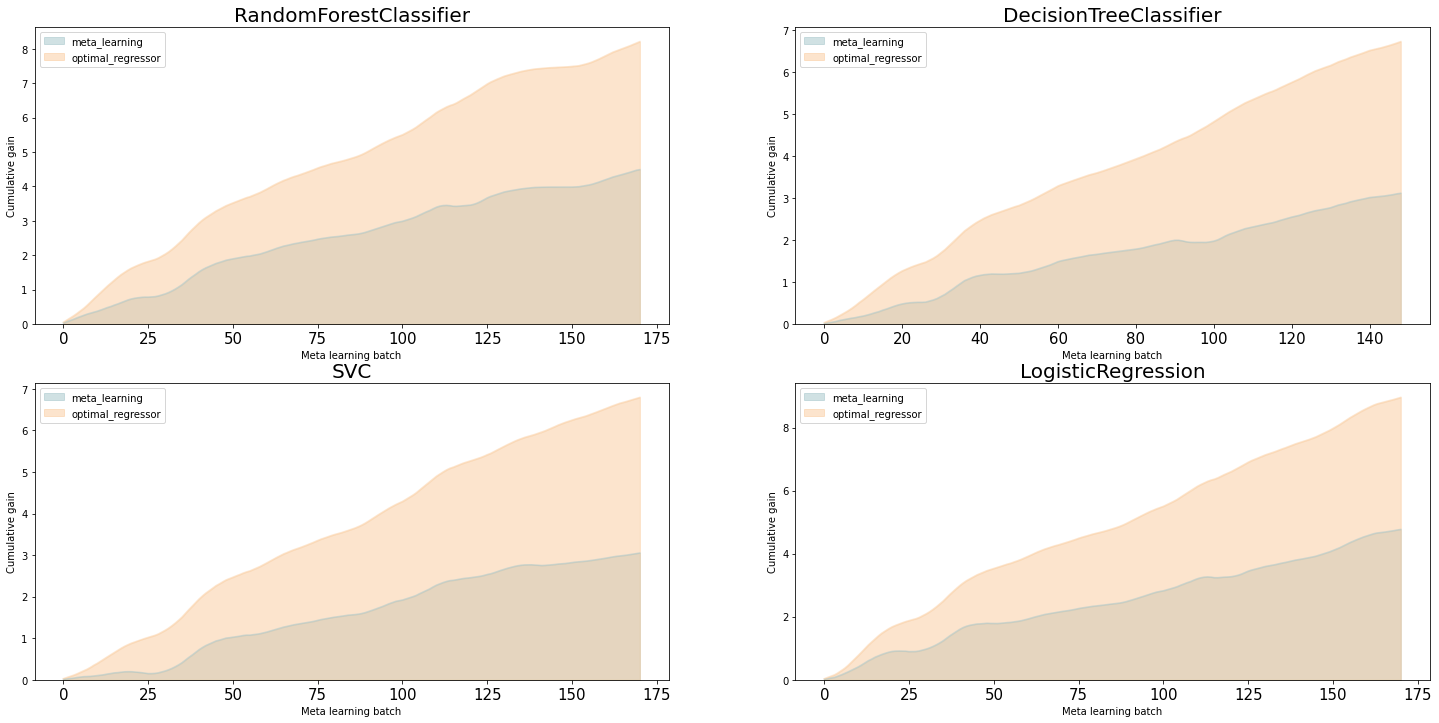

In [8]:
plt.figure(figsize=(25, 12))
for idx, base_model in enumerate(BASE_MODELS):
    meta_evals[base_model].plot_cumulative_gain(base_model, subplot_tuple=(2, 2, idx + 1))

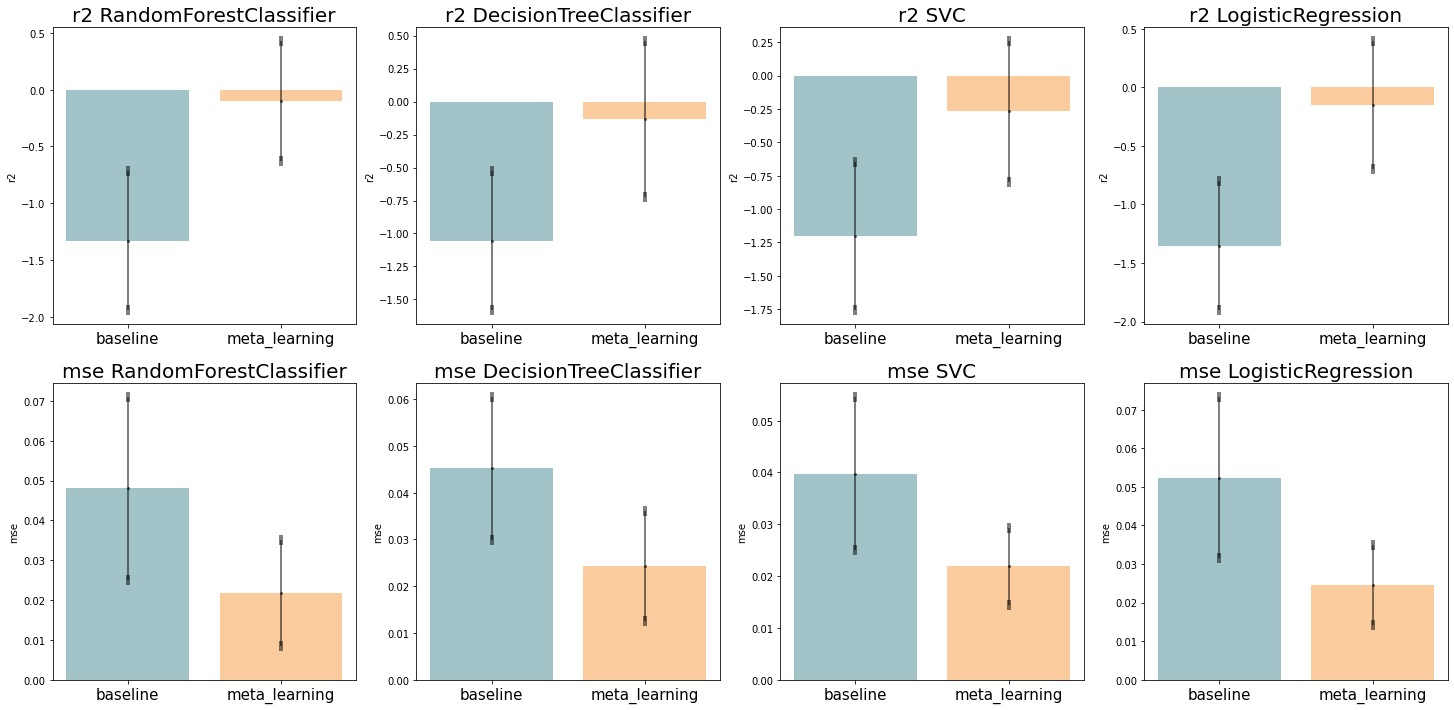

In [9]:
plt.figure(figsize=(25, 12))
plt.rc('xtick',labelsize=15)
for idx, base_model in enumerate(BASE_MODELS):
    plt.subplot(2, 4, idx+1)
    meta_evals[base_model].barchart_with_std("r2", base_model)
    plt.subplot(2, 4, idx+len(BASE_MODELS)+1)
    meta_evals[base_model].barchart_with_std("mse", base_model)